In [1]:
#capture --no-stderr
!pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
!pip install -U langchain_anthropic


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
os.environ ["LANGCHAIN_TRACING_V2"]  =  "true" 
os.environ ["LANGCHAIN_PROJECT"]="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"

os.environ["LANGCHAIN_API_KEY"]="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"
export ANTHROPIC_API_KEY="your-api-key"

In [3]:
#首先创建一个StateGraph。StateGraph对象将我们的聊天机器人的结构定义为“状态机”。我们将添加nodes以表示我们的聊天机器人可以调用的 llm 和函数，并edges指定机器人应如何在这些函数之间转换。

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
def chatbot(message, history):
    return {"messages": [llm.invoke(message)]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

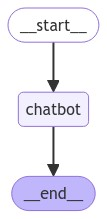

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:


import gradio as gr
gr.ChatInterface(chatbot).launch()


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"